In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# RNN with attention mechanism

In [2]:
class RNN:
    def __init__(self, X_nb_features, y_nb_features, time_steps, task='many-to-many', data_preprocessing=False,
                 rnn_units=32, activation='tanh', rnn_cell='rnn', kernel_initializer='glorot_normal', dropout=None,
                 opt='rmsprop', lr=0.001, loss='mse'):     
        self.__name__ = 'RNN'
        
        from keras.models import Sequential, Model
        from keras.layers import Dense, LSTM, SimpleRNN, GRU, Activation, TimeDistributed, Input, Permute, Reshape
        from keras.optimizers import Adam, SGD, RMSprop
        
        def attention_3d_block(inputs, time_steps, single_attention_vector=False):
            from keras.layers import Lambda, RepeatVector, Multiply, Softmax
            # inputs.shape = (batch_size, time_steps, input_dim)
            input_dim = int(inputs.shape[2])
            a = Permute((2, 1))(inputs)
            a = Reshape((input_dim, time_steps))(a) # this line is not useful. It's just to know which dimension is what.
            a = Dense(time_steps, activation='softmax')(a)
            if single_attention_vector:
                import keras.backend as K
                a = Lambda(lambda x: K.mean(x, axis=1), name='dim_reduction')(a)
                a = RepeatVector(input_dim)(a)
            a_probs = Permute((2, 1), name='attention_vec')(a)
            output_attention_mul = Multiply(name='attention_mul')([inputs, a_probs])
            return output_attention_mul
        
        rnn_cell_ = SimpleRNN if rnn_cell == 'rnn' else LSTM if rnn_cell == 'lstm' else GRU if rnn_cell == 'gru' else None
        
        inputs = Input(shape=(time_steps, X_nb_features))        
        attention = attention_3d_block(inputs, time_steps, single_attention_vector=(X_nb_features == 1))
        # print(f'attention.shape: {attention.shape}')
        if dropout is None:
            rnn = rnn_cell_(rnn_units, 
                            return_sequences=True if task=='many-to-many' else False, 
                            activation=activation, 
                            kernel_initializer=kernel_initializer)(attention)
        else:
            rnn = rnn_cell_(rnn_units, 
                            return_sequences=True if task=='many-to-many' else False, 
                            activation=activation, 
                            kernel_initializer=kernel_initializer, 
                            dropout=dropout)(attention) 
        if task == 'many-to-many':
            output = TimeDistributed(Dense(y_nb_features))(rnn)
            # output = Activation('linear')(output)
        elif task == 'many-to-one':
            output = Dense(y_nb_features)(rnn)
        model = Model(inputs=[inputs], outputs=output)

        opt_ = RMSprop(lr=lr) if opt == 'rmsprop' else Adam(lr=lr) if opt == 'adam' \
            else SGD(lr=lr) if opt == 'sgd' else None
        model.compile(loss=loss, optimizer=opt_)

        self.model = model
        self.data_preprocessing = data_preprocessing
        self.X_scaler, self.y_scaler = None, None
        self.X_features, self.y_features = None, None
        self.task = task  # 'many-to-many', 'many-to-one'
        self.time_steps = time_steps

    def fit(self, X, y, epochs=10, sample_weight=None, verbose=1, early_stopping_patience=50):
        if isinstance(X, pd.DataFrame) and isinstance(y, pd.DataFrame) and self.task == 'many-to-many':
            X_, y_ = X.copy(), y.copy()
            self.X_features, self.y_features = list(X_.columns), list(y_.columns)
            
            if self.data_preprocessing:
                from sklearn.preprocessing import MinMaxScaler, StandardScaler
                X_stationary, y_stationary = X_.copy(), y_.copy()
                self.X_scaler, self.y_scaler = StandardScaler(), StandardScaler()
                X_ = pd.DataFrame(data=self.X_scaler.fit_transform(X_stationary.values), index=X_stationary.index, columns=X_stationary.columns)
                y_ = pd.DataFrame(data=self.y_scaler.fit_transform(y_stationary.values), index=y_stationary.index, columns=y_stationary.columns)

            X_ = self.create_dataset(X_.values, self.time_steps)
            y_ = self.create_dataset(y_.values, self.time_steps)
            
        elif isinstance(X, np.ndarray) and isinstance(y, np.ndarray) and self.task == 'many-to-one':
            X_, y_ = X.copy(), y.copy()
        
        from keras.callbacks import ReduceLROnPlateau, EarlyStopping
        reduce_lr = ReduceLROnPlateau(monitor='loss', factor=0.5, patience=early_stopping_patience//2)
        early_stopping = EarlyStopping(monitor='loss', patience=early_stopping_patience)
        history = self.model.fit(X_, y_, epochs=epochs, callbacks=[reduce_lr, early_stopping],
                                 shuffle=False, sample_weight=sample_weight, verbose=verbose)
        return history
        
    def predict(self, X, return_sequence=False):
        """
        Predict for Seq2Seq translation
        indicator_keys = X_indicators + y_indicators
        df = get_time_points(session=ses, indicator_keys=indicator_keys).dropna()
        df_train = df.loc[:'2014-03-31'].iloc[:-1]
        model = RNN(
        X_nb_features=len(X_indicators), y_nb_features=len(y_indicators),
        data_preprocessing=True, task='translation',
        activation='tanh', opt='rmsprop', rnn_cell='rnn', rnn_units=32
        )
        # model.model.summary()
        model.fit(X=df_train[X_indicators], y=df_train[y_indicators], epochs=1000, verbose=1)
        y_pred = model.predict(X=df[X_indicators], y_first_row=df[y_indicators].iloc[[0]])
        
        :param X:
        :param y_first_row:
        :param return_sequence: for many-to-many case only
        :return:
        """
        if isinstance(X, pd.DataFrame) and self.task == 'many-to-many':
            X_ = X.copy()
            if self.data_preprocessing:
                X_ = pd.DataFrame(data=self.X_scaler.transform(X_stationary.values), index=X_stationary.index,
                                  columns=X_stationary.columns)
            X_ = self.create_dataset(X_.values, self.time_steps)
            # print(f'X: {X_}')

            forecast = self.model.predict(X_)
            # print(f'forecast: {forecast}')
            
            if not return_sequence:
                pred = np.array([sample[-1] for sample in forecast])
                pred = pd.DataFrame(data=pred, index=X.index[self.time_steps-1 + int(self.data_preprocessing):], columns=self.y_features)

                if self.data_preprocessing:
                    pred = pd.DataFrame(data=self.y_scaler.inverse_transform(pred), index=pred.index, columns=pred.columns)
            else:
                pred = []
                for i, sample in enumerate(forecast):
                    # print(X.index[int(self.data_preprocessing)+i:int(self.data_preprocessing)+i+self.time_steps])
                    pred.append(pd.DataFrame(
                        data=sample, 
                        index=X.index[int(self.data_preprocessing)+i:int(self.data_preprocessing)+i+self.time_steps],
                        columns=self.y_features))

                    if self.data_preprocessing:
                        pred[-1] = pd.DataFrame(data=self.y_scaler.inverse_transform(pred[-1]), index=pred[-1].index, columns=pred[-1].columns)

            return pred
        elif isinstance(X, np.ndarray) and self.task == 'many-to-one':
            pred = self.model.predict(X.copy())
            return pred
        

    @staticmethod
    def create_dataset(dataset, look_back=1):
        dataX = []
        for i in range(len(dataset)-look_back+1):
            a = dataset[i:(i+look_back), :]
            dataX.append(a)
        return np.array(dataX)
    
    
    def visualize_layer_output(self, layer_name, X):
        import keras.backend as K

        layer = self.model.get_layer(layer_name)
        inputs = [K.learning_phase()] + self.model.inputs
        _output_f = K.function(inputs, [layer.output])
        output_f = lambda x: _output_f([0] + [x])  # The [0] is to disable the training phase flag
        
        X_ = X.copy()
        if self.task == 'many-to-many' and isinstance(X, pd.DataFrame):
            if self.data_preprocessing:
                X_stationary = X_.copy()
                X_ = pd.DataFrame(data=self.X_scaler.transform(X_stationary.values), index=X_stationary.index,
                                      columns=X_stationary.columns)
            X_ = self.create_dataset(X_.values, self.time_steps)
        
            # print('output_f([X_]'), print(output_f(X_)), print()
            output = output_f(X_)
            output = []
            for X_sample in X_:
                output.append(output_f([X_sample])[0])
            # print('output'), print(output)
        
            outputs = []
            inputs = []
            X_for_analysis = X.copy().diff().iloc[1:].rename(columns={f: f'{f}_diff' for f in self.X_features}) if self.data_preprocessing else X.copy()
            X_for_analysis_ = self.create_dataset(X_for_analysis.values, self.time_steps)

            for i, sample in enumerate(output):
                # print(f'output {i+1}'), print(sample), print()
                outputs.append(pd.DataFrame(
                    data=sample[0],
                    index=X.index[int(self.data_preprocessing)+i:int(self.data_preprocessing)+i+self.time_steps],
                    columns=self.X_features
                ))
                inputs.append(pd.DataFrame(
                    data=X_for_analysis_[i],
                    index=X.index[int(self.data_preprocessing)+i:int(self.data_preprocessing)+i+self.time_steps],
                    columns=X_for_analysis.columns
                ))
        
        elif self.task == 'many-to-one' and isinstance(X, np.ndarray):
            outputs = output_f(X_)[0]
            inputs = X_.copy()
            
        return outputs, inputs

# Attention with many-to-one RNN architecture

In [60]:
def get_data_recurrent_many_to_one(n, time_steps, input_dim, attention_time=1):
    """
    Data generation. x is purely random except that it's first value equals the target y.
    In practice, the network should learn that the target = x[attention_column].
    Therefore, most of its attention should be focused on the value addressed by attention_column.
    :param n: the number of samples to retrieve.
    :param time_steps: the number of time steps of your series.
    :param input_dim: the number of dimensions of each element in the series.
    :param attention_column: the column linked to the target. Everything else is purely random.
    :return: x: model inputs, y: model targets
    """
    x = np.random.standard_normal(size=(n, time_steps, input_dim))/10
    y = np.random.randint(low=0, high=2, size=(n, 1))
    x[:, attention_time, :] = np.tile(y[:], (1, input_dim))
    return x, y

In [61]:
time_steps = 20
X, y = get_data_recurrent_many_to_one(300000, time_steps, input_dim=1)
for i, o in list(zip(X, y))[:2]:
    print('input:'), print(i)
    print('output:'), print(o)

X_train, X_test = X[:int(len(X)*0.7)], X[int(len(X)*0.7):]
y_train, y_test = y[:int(len(X)*0.7)], y[int(len(X)*0.7):]

input:
[[-0.04064237]
 [ 0.        ]
 [ 0.0193855 ]
 [ 0.03510364]
 [ 0.19271498]
 [-0.03468337]
 [ 0.09214807]
 [-0.09492595]
 [ 0.01104966]
 [-0.10504325]
 [-0.00613826]
 [ 0.06400849]
 [ 0.14344168]
 [-0.15946828]
 [-0.00440963]
 [ 0.14236782]
 [-0.06922806]
 [-0.06719547]
 [-0.00042833]
 [-0.09433335]]
output:
[0]
input:
[[-0.19620024]
 [ 1.        ]
 [-0.11814989]
 [ 0.05983911]
 [-0.04151838]
 [ 0.02600053]
 [-0.20313317]
 [ 0.04287749]
 [-0.06431892]
 [ 0.03365126]
 [-0.0151108 ]
 [-0.09663294]
 [ 0.27029651]
 [ 0.04742901]
 [ 0.24279075]
 [ 0.13147347]
 [-0.02232285]
 [-0.05608875]
 [-0.08675582]
 [-0.09274465]]
output:
[1]


### Fit network

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_18 (InputLayer)           (None, 20, 1)        0                                            
__________________________________________________________________________________________________
permute_18 (Permute)            (None, 1, 20)        0           input_18[0][0]                   
__________________________________________________________________________________________________
reshape_18 (Reshape)            (None, 1, 20)        0           permute_18[0][0]                 
__________________________________________________________________________________________________
dense_35 (Dense)                (None, 1, 20)        420         reshape_18[0][0]                 
__________________________________________________________________________________________________
dim_reduct

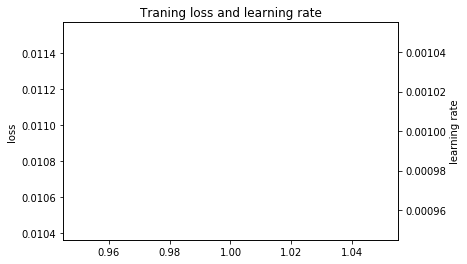

In [68]:
model = RNN(
    X_nb_features=X_train[0].shape[1], y_nb_features=y.shape[1], time_steps=time_steps,
    data_preprocessing=False,
    task='many-to-one',
    rnn_cell='lstm', rnn_units=32, dropout=None,
)
model.model.summary()

learning_history = model.fit(
    X=X_train,
    y=y_train,
    epochs=1,
    verbose=1
)

fig, ax1 = plt.subplots()
ax2 = ax1.twinx()
ax1.plot(range(1, len(learning_history.history['loss'])+1), learning_history.history['loss'])
ax2.plot(range(1, len(learning_history.history['lr'])+1), learning_history.history['lr'], 'g-')
plt.xlabel('epoch'), ax1.set_ylabel('loss'), ax2.set_ylabel('learning rate'), plt.title('Traning loss and learning rate')
plt.show()

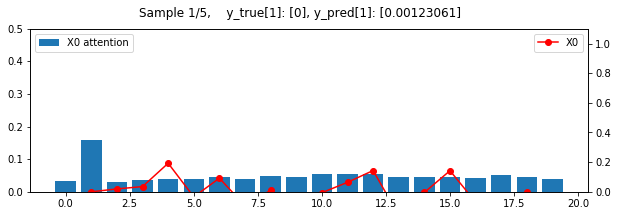

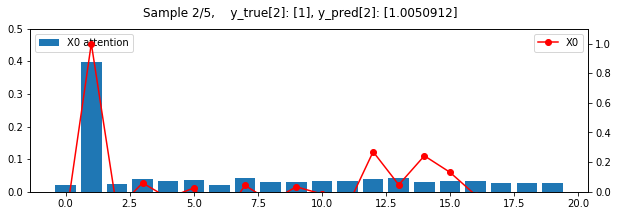

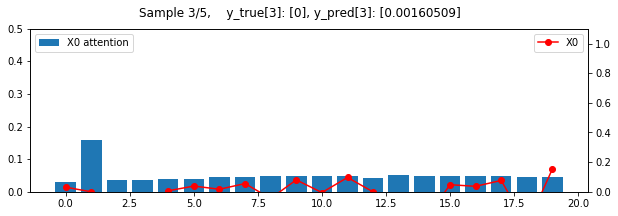

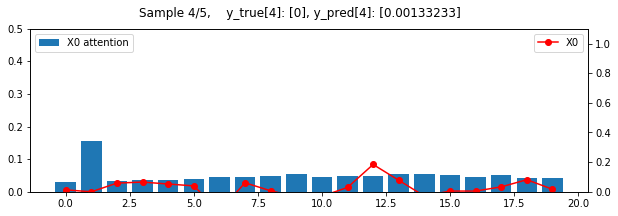

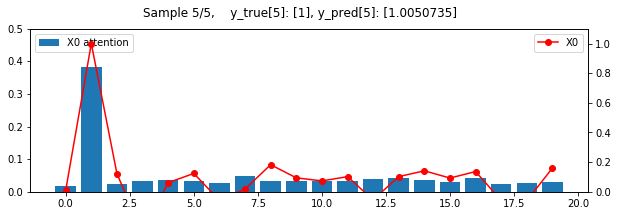

In [70]:
sample_indices = 0, 5
X_sample = X[sample_indices[0]:sample_indices[1]]
y_true_sample = y[sample_indices[0]:sample_indices[1]]

# print('X_sample'), print(X_sample), print()
# print('y_true_sample'), print(y_true_sample), print()

preds = model.predict(X=X_sample)
# print('pred'), print(preds)

attentions, inputs = model.visualize_layer_output(layer_name='attention_vec', X=X_sample)
# print('attentions'), print(attentions), print()
# print('inputs'), print(inputs), print()


for i, p in enumerate(preds):
    fig, ax = plt.subplots(X_sample[0].shape[1], 1, figsize=(10, 3))
    fig.suptitle(f'Sample {i+1}/{len(preds)},    ' + \
                 f'y_true[{i+1}]: {y_true_sample[i]}, ' * (y_true_sample is not None) +\
                 f'y_pred[{i+1}]: {p}')
    
    for x_factor in range(attentions[i].shape[1]): 
        ax1 = ax[x_factor] if X_sample[0].shape[1] > 1 else ax        
        ax2 = ax1.twinx()
        ax1.bar(list(range(len(attentions[i][:, x_factor]))), np.abs(attentions[i][:, x_factor]), label=f'X{x_factor} attention')
        ax1.set_ylim(0, 0.5)
        ax2.plot(list(range(len(inputs[i][:, x_factor]))), inputs[i][:, x_factor], 'r-o', label=f'X{x_factor}')
        ax2.set_ylim(0, 1.1)
        ax1.legend(loc='upper left'), ax2.legend(loc='upper right')
        plt.xlabel('time step')
    plt.show()

# Attention with many-to-many RNN architecture

In [44]:
def get_data_recurrent_many_to_many(n, time_steps, input_dim=1, attention_column=1, look_back=1):
    """
    Data generation. x is purely random except that it's first value equals the target y.
    In practice, the network should learn that the target = x[attention_column].
    Therefore, most of its attention should be focused on the value addressed by attention_column.
    :param n: the number of samples to retrieve.
    :param time_steps: the number of time steps of your series.
    :param input_dim: the number of dimensions of each element in the series.
    :param attention_column: the column linked to the target. Everything else is purely random.
    :return: x: model inputs, y: model targets
    """
    x = np.random.standard_normal(size=(n, time_steps, input_dim))/10
    y_ = np.random.randint(low=0, high=2, size=(n, 1))
    x[:, attention_column, :] = np.tile(y_[:], (1, input_dim))
    y = np.random.standard_normal(size=(n, time_steps, input_dim))/10
    y[:, attention_column+look_back, :] = np.tile(y_[:], (1, input_dim))
    return x, y

In [49]:
time_steps = 15

inputs, outputs = get_data_recurrent_many_to_many(10000, time_steps, look_back=5)
for i, o in list(zip(inputs, outputs))[:1]:
    print('input:'), print(i)
    print('output:'), print(o)
inputs = inputs.reshape(-1, inputs.shape[2])
outputs = outputs.reshape(-1, outputs.shape[2])

df = pd.DataFrame()
df['X'] = inputs[:, 0]
df['y'] = outputs[:, 0]
df_train = df.iloc[:int(len(df)*0.7)]

X_indicators = ['X']
y_indicators = ['y']
# df.plot(figsize=(10, 5))

input:
[[ 0.02647008]
 [ 0.        ]
 [ 0.08586887]
 [-0.14611982]
 [-0.0268354 ]
 [-0.07278135]
 [ 0.03175535]
 [-0.14044173]
 [-0.05718181]
 [-0.03222377]
 [ 0.17591965]
 [ 0.00690429]
 [-0.03514282]
 [ 0.08141451]
 [ 0.01150394]]
output:
[[-0.08510026]
 [ 0.04631086]
 [-0.10700298]
 [-0.04102842]
 [ 0.02046967]
 [ 0.02857936]
 [ 0.        ]
 [ 0.06097027]
 [-0.06999484]
 [ 0.04891958]
 [-0.09882501]
 [-0.02217758]
 [ 0.10766732]
 [-0.06476679]
 [ 0.03648408]]


### Fit network

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_15 (InputLayer)           (None, 15, 1)        0                                            
__________________________________________________________________________________________________
permute_15 (Permute)            (None, 1, 15)        0           input_15[0][0]                   
__________________________________________________________________________________________________
reshape_15 (Reshape)            (None, 1, 15)        0           permute_15[0][0]                 
__________________________________________________________________________________________________
dense_29 (Dense)                (None, 1, 15)        240         reshape_15[0][0]                 
__________________________________________________________________________________________________
dim_reduct

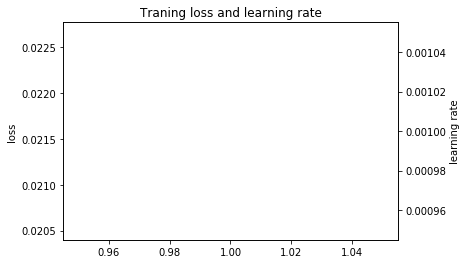

In [51]:
model = RNN(
    X_nb_features=len(X_indicators), y_nb_features=len(y_indicators), time_steps=time_steps,
    data_preprocessing=False,
    task='many-to-many',
    rnn_cell='rnn', rnn_units=32, dropout=None,
)
model.model.summary()

learning_history = model.fit(
    X=df_train[X_indicators],
    y=df_train[y_indicators],
    epochs=1,
    verbose=1
)

fig, ax1 = plt.subplots()
ax2 = ax1.twinx()
ax1.plot(range(1, len(learning_history.history['loss'])+1), learning_history.history['loss'])
ax2.plot(range(1, len(learning_history.history['lr'])+1), learning_history.history['lr'], 'g-')
plt.xlabel('epoch'), ax1.set_ylabel('loss'), ax2.set_ylabel('learning rate'), plt.title('Traning loss and learning rate')
plt.show()

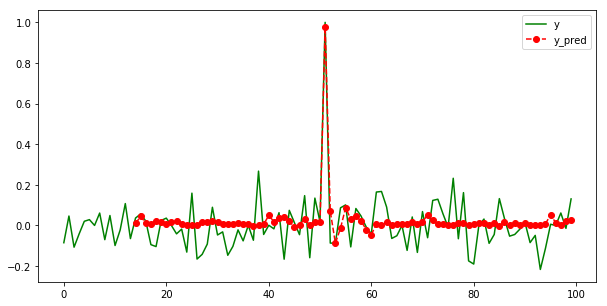

In [57]:
y_pred = model.predict(X=df[X_indicators].iloc[:100])
# y_pred = model.predict(X=df_train[X_indicators].iloc[:5])
# y_pred = model.predict(X=df[X_indicators].iloc[:])

# PLOT PREDICTIONS
for col in y_indicators:
    fig, ax = plt.subplots(figsize=(10, 5))
    # ax.plot(df_train.index, df_train[col], 'b-', label=col + ' actual train')
    ax.plot(df.iloc[:100].index, df[col].iloc[:100], 'g-')
    # ax.plot(df.loc[df_train.index[-1]:].index, df[col].loc[df_train.index[-1]:], 'g-', label=col + ' actual test')
    ax.plot(y_pred.index, y_pred[col], 'r--o', label='y_pred')
    ax.legend(loc='best')
plt.show()

X_sample
            X
150 -0.090973
151  1.000000
152  0.052867
153 -0.144903
154  0.161522
155  0.041663
156 -0.094762
157 -0.165462
158 -0.071149
159  0.126902
160 -0.050302
161 -0.002856
162 -0.003383
163  0.090564
164 -0.005505
165 -0.036821
166  0.000000
167  0.024969
168  0.081865

y_true_sample
            y
150 -0.009426
151 -0.287286
152  0.091802
153  0.140808
154  0.028256
155  0.054252
156  1.000000
157  0.093207
158 -0.049752
159  0.004958
160  0.123106
161 -0.160770
162  0.081436
163 -0.076836
164 -0.124367
165  0.067692
166 -0.020787
167  0.043995
168 -0.265034



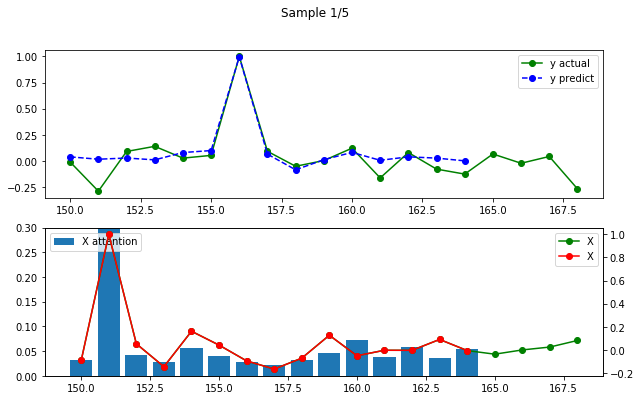

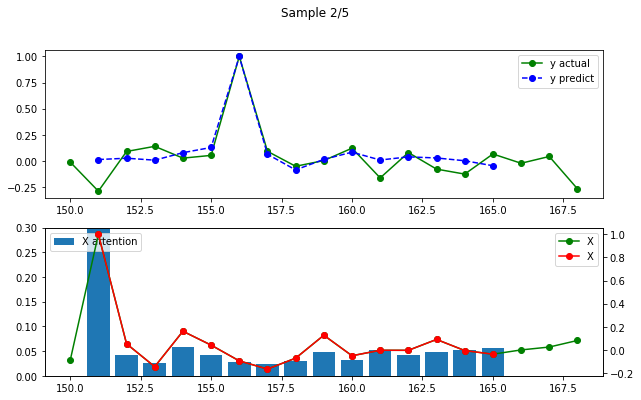

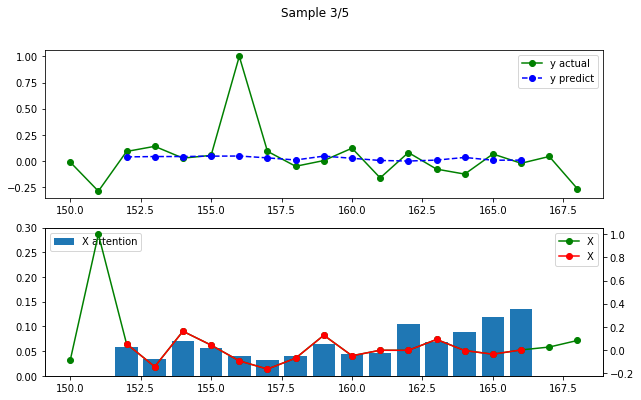

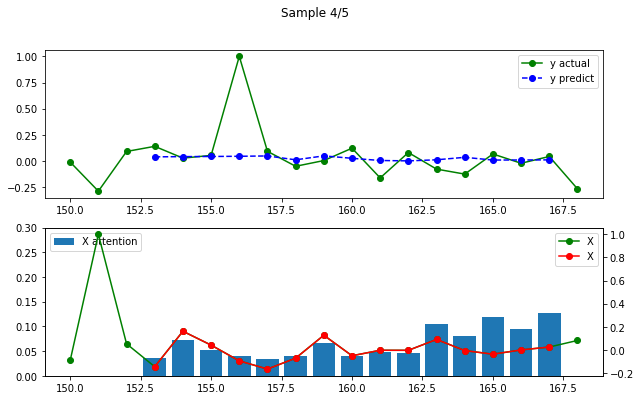

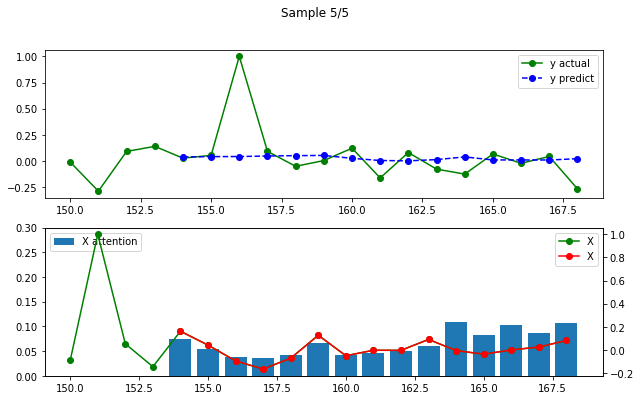

In [58]:
sample_number = 10
number_of_samples = 4
sample_indices = time_steps*sample_number, time_steps*(sample_number+1)+number_of_samples
X_sample = df[X_indicators].iloc[sample_indices[0]:sample_indices[1]]
y_true_sample = df[y_indicators].iloc[sample_indices[0]:sample_indices[1]]

print('X_sample'), print(X_sample), print()
print('y_true_sample'), print(y_true_sample), print()

preds = model.predict(X=X_sample, return_sequence=True)
# print('pred')
# for p in preds:
#     print(p)

attentions, inputs = model.visualize_layer_output(layer_name='attention_vec', X=X_sample)

for i, p in enumerate(preds):
    fig, ax = plt.subplots(len(X_indicators) + len(y_indicators), 1, figsize=(10, 6))
    fig.suptitle(f'Sample {i+1}/{len(preds)}')
    for j, y_ind in enumerate(p):
        if y_true_sample is not None:
            y_true_sample[y_ind].plot(ax=ax[j], style='g-o', label=f'{y_ind} actual')
        p[y_ind].plot(ax=ax[j], style='b--o', label=f'{y_ind} predict')
        ax[j].legend(loc='upper right')
            
    for k, x_factor in enumerate(attentions[i]): 
        ax22 = ax[p.shape[1]+k].twinx()
        ax[p.shape[1]+k].bar(attentions[i][x_factor].index, np.abs(attentions[i][x_factor].values), label=f'{x_factor} attention')
        ax[p.shape[1]+k].set_ylim(0, 0.3)
        ax22.plot(X_sample[x_factor].index, X_sample[x_factor].values, 'g-o', label=x_factor)
        ax22.plot(inputs[i].iloc[:, k].index, inputs[i].iloc[:, k], 'r-o', label=x_factor)
        ax[p.shape[1]+k].legend(loc='upper left'), ax22.legend(loc='upper right')
    plt.show()